In [1]:
%matplotlib inline
import warnings; warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import keras
from keras import models
from keras import layers

Using TensorFlow backend.


In [2]:
df = pd.read_csv('small_strato/small_strato.dat',
                delim_whitespace=True, header=None, index_col=0)
df.columns = ['SUN', 'O1D', 'O', 'O3', 'NO', 'NO2', 'M', 'O2']
df.index.name = 'time'

df = df.apply(pd.to_numeric, errors='coerce')
df[np.isnan(df)] = 0.0

df.drop(['M', 'O2'], axis=1, inplace=True)
StandardScaler(copy=False).fit_transform(df.values);

In [3]:
df.head()

,SUN,O1D,O,O3,NO,NO2
time,,,,,,
0.00,-0.995343,0.681481,0.624369,-5.276847,1.002615,-1.002615
0.25,1.323605,0.690792,0.645583,-5.179657,1.174745,-1.174745
0.50,1.323499,0.705273,0.659935,-5.083862,1.172798,-1.172798
0.75,1.323040,0.719120,0.673739,-4.989020,1.170828,-1.170828
1.00,1.321804,0.731721,0.686491,-4.895218,1.168762,-1.168762


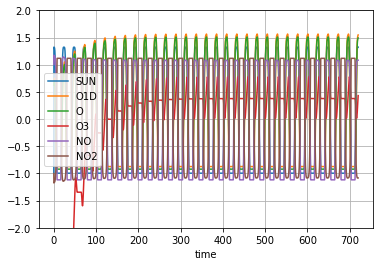

In [4]:
df.plot(y=['SUN', 'O1D', 'O', 'O3', 'NO', 'NO2'], #df.columns.drop('time'),
        ylim=[-2, 2], grid=True)

In [5]:
X = df.values
X.shape

(2881, 6)

In [6]:
Y = df.drop('SUN', axis=1).values
Y.shape

(2881, 5)

In [7]:
network = models.Sequential()
network.add(layers.Dense(20, activation='relu', input_shape=(6,)))
#network.add(layers.BatchNormalization())
network.add(layers.Dense(20, activation='relu'))
#network.add(layers.BatchNormalization())
network.add(layers.Dense(5, activation=None))


In [8]:
network.compile(optimizer=keras.optimizers.Adam(lr=0.01), 
                loss='mse')
network.fit(X, Y, epochs=3, steps_per_epoch=1000, verbose=1)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/3
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0078
Epoch 2/3
1000/1000 [==============================] - 2s 2ms/step - loss: 4.4910e-05
Epoch 3/3
1000/1000 [==============================] - 2s 2ms/step - loss: 3.7392e-05


In [9]:
%time y_pred = network.predict(X)

CPU times: user 47.7 ms, sys: 6.66 ms, total: 54.4 ms
Wall time: 42.6 ms


In [10]:
r2_score(y_pred, Y)

0.9999689903690836

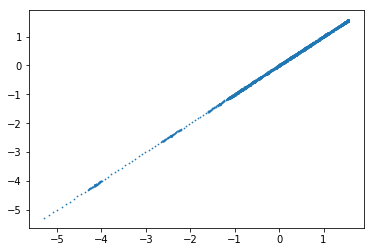

In [11]:
plt.scatter(y_pred.ravel(), Y.ravel(), s=0.5)

# Predict history

In [12]:
sun = df['SUN'].values
sun.shape

(2881,)

In [13]:
%%time
pred_history = []
for t in range(X.shape[0]-1):
    x_temp = X[t].reshape(1,-1) # column vector
    y_temp = network.predict(x_temp)
    
    pred_history.append(y_temp.ravel().copy())
    
    # prepare for next step
    x_temp = np.c_[sun[t+1], y_temp]
    
pred_history = np.array(pred_history)

CPU times: user 1.11 s, sys: 138 ms, total: 1.25 s
Wall time: 952 ms


In [14]:
pred_history.shape

(2880, 5)

In [15]:
df_pred = pd.DataFrame(pred_history, index=df.index[1:], 
                       columns=['O1D', 'O', 'O3', 'NO', 'NO2'])
df_pred.head()

,O1D,O,O3,NO,NO2
time,,,,,
0.25,0.699538,0.574946,-5.286877,1.007001,-0.998409
0.50,0.677701,0.668188,-5.180058,1.172382,-1.180035
0.75,0.691130,0.680790,-5.084616,1.168830,-1.175677
1.00,0.703951,0.692846,-4.990122,1.165267,-1.171306
1.25,0.716669,0.704678,-4.896738,1.162783,-1.168533


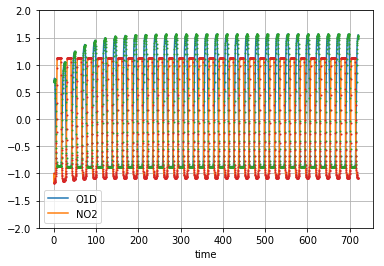

In [16]:
specs = ['O1D', 'NO2'] # ['O1D', 'O', 'O3', 'NO', 'NO2']

ax = df.plot(y=specs, ylim=[-2, 2], grid=True)

df_pred.plot(y=specs, ylim=[-2, 2], grid=True,
             marker='.', markersize=2.0, linewidth=0.0, ax=ax, legend=False)

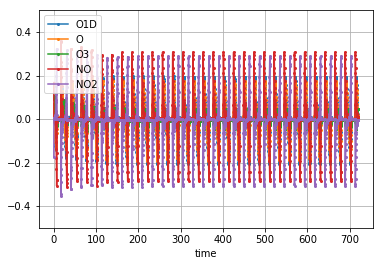

In [17]:
(df.iloc[1:] - df_pred).plot(y=['O1D', 'O', 'O3', 'NO', 'NO2'],
                             ylim=[-0.5, 0.5], grid=True,
                             marker='o', markersize=2.0,)

In [18]:
r2_score(df['NO2'].iloc[1:], df_pred['NO2'])

0.99092712640323966

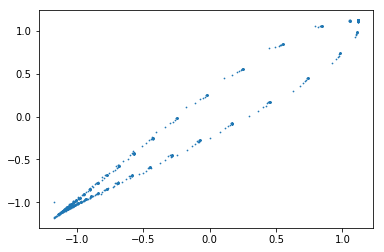

In [19]:
plt.scatter(df['NO2'].iloc[1:], df_pred['NO2'], s=0.5)

# Pytorch

In [20]:
import torch
from torch.autograd import Variable

In [21]:
x = Variable(torch.from_numpy(X).type(torch.FloatTensor))
y = Variable(torch.from_numpy(Y.reshape(-1,1)).type(torch.FloatTensor))

In [22]:
H1, H2 = 10, 10

model = torch.nn.Sequential(
    torch.nn.Linear(6, H1),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 5)
)

In [23]:
loss_fn = torch.nn.MSELoss()

# LBFGS can make error very small
#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for t in range(500):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%50==0:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        print(t+1, loss.data[0])

50 0.005902471020817757
100 0.0016512585571035743
150 0.0008614534744992852
200 0.0005453824996948242
250 0.00038326007779687643
300 0.00028573759482242167
350 0.00022091501159593463
400 0.00017292241682298481
450 0.00013502671208698303
500 0.00010509319690754637


In [28]:
%time y_pred = model(x)

CPU times: user 3.44 ms, sys: 797 µs, total: 4.24 ms
Wall time: 2.49 ms


In [29]:
r2_score(y_pred.data.numpy(), Y)

0.99989485624590968